In [1]:
import zipfile, io
import os
import re
import glob

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def moving_average(data, window):
    padding_num = int(np.floor(window / 2))
    start_padding = data[:padding_num].mean().repeat(padding_num)
    end_padding = data[len(data)-padding_num:].mean().repeat(padding_num)

    values = np.concatenate([start_padding, data, end_padding])

    ret = np.cumsum(values, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window


class MovingAverager:
    def __init__(self, windows):
        if isinstance(windows, List):
            self.windows = windows
        elif isinstance(windows, int):
            self.windows = [windows]
        self.max_window = max(self.windows)
    
    def execute(self, data):
        assert len(data) >= self.max_window
        
        result = np.zeros(len(data))

        for window in self.windows:
            result += moving_average(data=data, window=window)
        result /= len(self.windows)

        return result

In [3]:
def read_from_folder(folder):
    acc_df = pd.read_csv(os.path.join(folder, 'Accelerometer.csv'))
    lin_acc_df = pd.read_csv(os.path.join(folder, 'Linear Accelerometer.csv'))
    mag_df = pd.read_csv(os.path.join(folder, 'Magnetometer.csv'))
    gyro_df = pd.read_csv(os.path.join(folder, 'Gyroscope.csv'))
    
    total_df = pd.concat([acc_df, gyro_df, lin_acc_df, mag_df], axis=1)
    return total_df


def rename_data(df):
#     new_names = ['acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    new_names = ['times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    return df


def gen_total_mag(df: pd.DataFrame):
    df['mag_t'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2) + (df['mag_z'] ** 2))
    return df


def smooth(df):
    for column in df.columns:
        if 'time' in column:
            continue
        df[column] = moving_average(df[column], 5)
    return df


def select_data(df):
    return df[['times', 'acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'mag_t']]


def bound_range(df, datapoint_per_second=20):
    start = int(datapoint_per_second * 1.0)
    end = int(len(df) - datapoint_per_second * 1.0)
    
    return df.iloc[start:end].reset_index(drop=True)


def load_data(folder):
    total_df = read_from_folder(folder)
    total_df = total_df[:-5]  # remove last None value row
    total_df = rename_data(total_df)
    
    total_df = gen_total_mag(total_df)
    total_df = smooth(total_df)
    
    total_df = select_data(total_df)
    total_df = bound_range(total_df)
    
    return total_df

In [5]:
all_data = {}

for user_folder in sorted(glob.glob('./User*')):
    user = user_folder.split('/')[-1]
    all_data[user] = {}
    
    for path_folder in sorted(glob.glob(os.path.join(user_folder, 'path*'))):   
        path = path_folder.split('/')[-1]
#         try:
        temp = {}
        for i, posture_folder in enumerate(sorted(glob.glob(os.path.join(path_folder, '*[!zip]')))):
            posture = posture_folder.split('/')[-1]
            
            print(posture_folder)

            df = load_data(posture_folder)
            temp[posture] = df.to_numpy()
                
#         except Exception as e:
#             print(path_folder)
#             print(e)
#             continue
        
        all_data[user][path] = temp

./User1/path2/front_pocket
./User1/path2/horizontal
./User1/path2/pocket
./User1/path2/swing
./User1/path2/target
./User1/path3/front_pocket
./User1/path3/horizontal
./User1/path3/pocket
./User1/path3/swing
./User1/path3/target
./User1/path4/front_pocket
./User1/path4/horizontal
./User1/path4/pocket
./User1/path4/swing
./User1/path4/target
./User1/path5/front_pocket
./User1/path5/horizontal
./User1/path5/pocket
./User1/path5/swing
./User1/path5/target
./User2/path1/front_pocket
./User2/path1/horizontal
./User2/path1/pocket
./User2/path1/swing
./User2/path1/target
./User2/path2/front_pocket
./User2/path2/horizontal
./User2/path2/pocket
./User2/path2/swing
./User2/path2/target
./User2/path3/front_pocket
./User2/path3/horizontal
./User2/path3/pocket
./User2/path3/swing
./User2/path3/target
./User2/path4/front_pocket
./User2/path4/horizontal
./User2/path4/pocket
./User2/path4/swing
./User2/path4/target
./User2/path5/front_pocket
./User2/path5/horizontal
./User2/path5/pocket
./User2/path5/s

In [6]:
def read_data(path):
    data = []
    
    for file_path in glob.glob(f'{path}/**/Magnetometer.csv', recursive=True):
        df = pd.read_csv(file_path, delimiter='\t')
        cord = file_path.split('/')[-2].split('_')[2:]
        cord = (float(cord[0]), float(cord[1]))
        
        mean_mag = df[["X (µT)", "Y (µT)", "Z (µT)"]].mean().to_numpy()
#         data.append(np.concatenate((cord, mean_mag)))
        data.append(np.concatenate((cord, mean_mag)))
        
    return np.array(data)

# grid_data = read_data('/root/Calibration/PhyPhox/Grid/')
# grid_data[:, :2] = grid_data[:, :2] - np.array((1, 1))
# grid_data = grid_data[np.lexsort((grid_data[:, 1], grid_data[:, 0]))]
# grid_data.shape

In [ ]:
grids = []
grid_dict = {}
        
for folder in sorted(os.listdir('./R403_grids/')):
    if os.path.isfile(f'./R403_grids/{folder}') or folder.startswith('_') or folder.startswith('.'):
        continue
    print(folder)
    
    for name in sorted(os.listdir(f'./R403_grids/{folder}/')):
        if name.endswith('.zip') and not name.startswith('__'):
            cord = name[:-4].split('-')[-2:]
            cord = np.array([float(cord[0]), float(cord[1])])

            path = f'./R403_grids/{folder}/{name}'
            with zipfile.ZipFile(path, 'r') as sub_zipfile:

                with sub_zipfile.open('Raw Data.csv', 'r') as csv_file:
                    df = pd.read_csv(csv_file, delimiter=',')

                    row = df.mean()
                    row['cord_x'] = cord[1]
                    row['cord_y'] = cord[0]

                    point = row[['cord_y', 'cord_x', 'Magnetic Field x (µT)', 'Magnetic Field y (µT)', 'Magnetic Field z (µT)', 'Absolute field (µT)']].to_numpy()
                    grids.append(point)
                    grid_dict[(cord[1], cord[0])] = row[['Magnetic Field x (µT)', 'Magnetic Field y (µT)', 'Magnetic Field z (µT)', 'Absolute field (µT)']].to_numpy()

In [7]:
grid_data = read_data('/root/Calibration/PhyPhox/Grid/')
grid_data[:, :2] = grid_data[:, :2] - np.array((1, 1))
grid_data = grid_data[np.lexsort((grid_data[:, 1], grid_data[:, 0]))]

In [8]:
user_path = defaultdict(dict)

for folder in glob.glob('./User*path*'):
    user_name = re.search(r'User\d', folder)[0]
    
    user_path[user_name] = np.load(folder, allow_pickle=True).item()

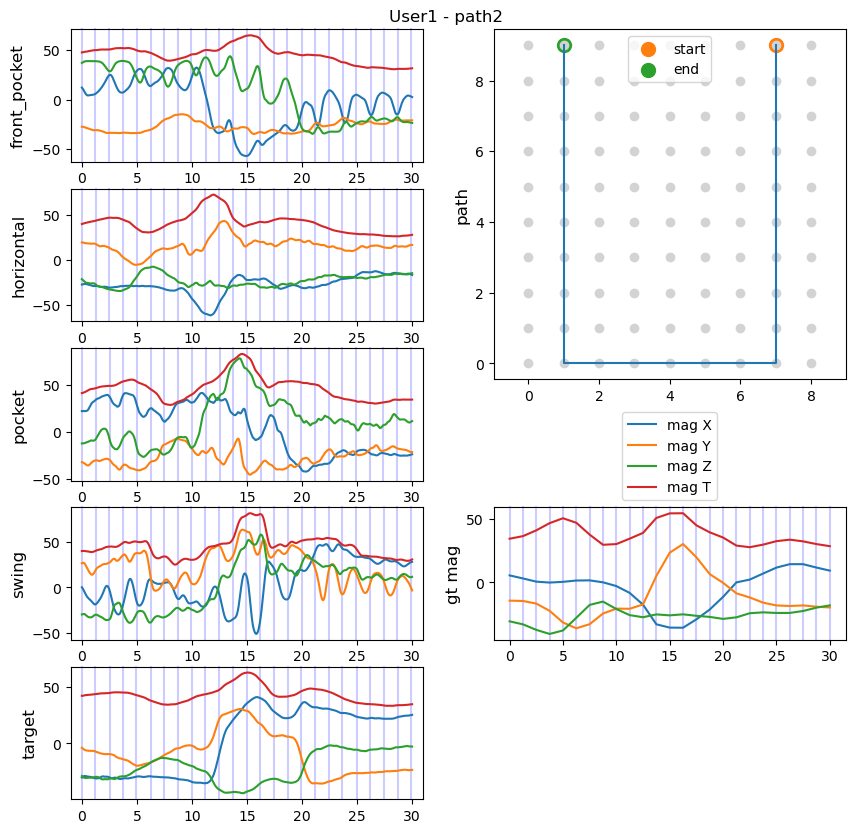

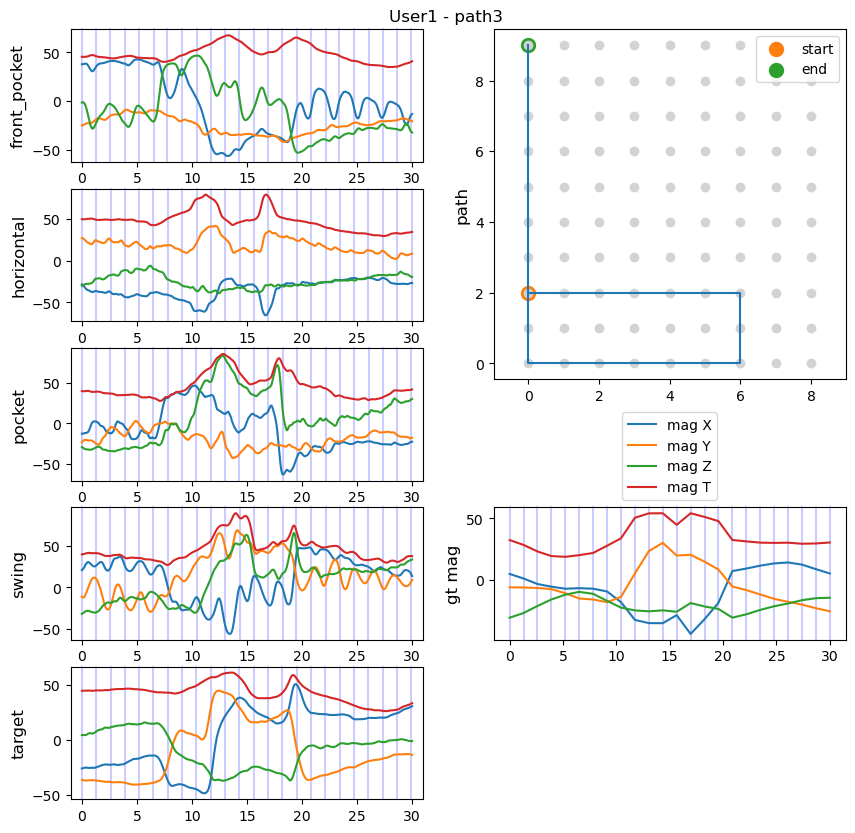

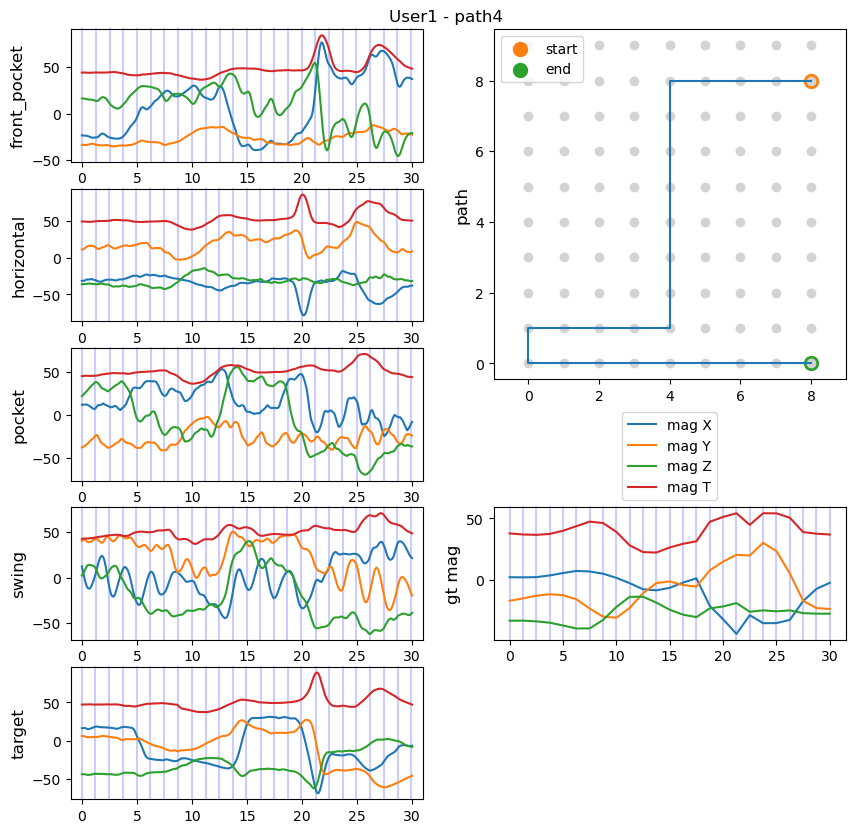

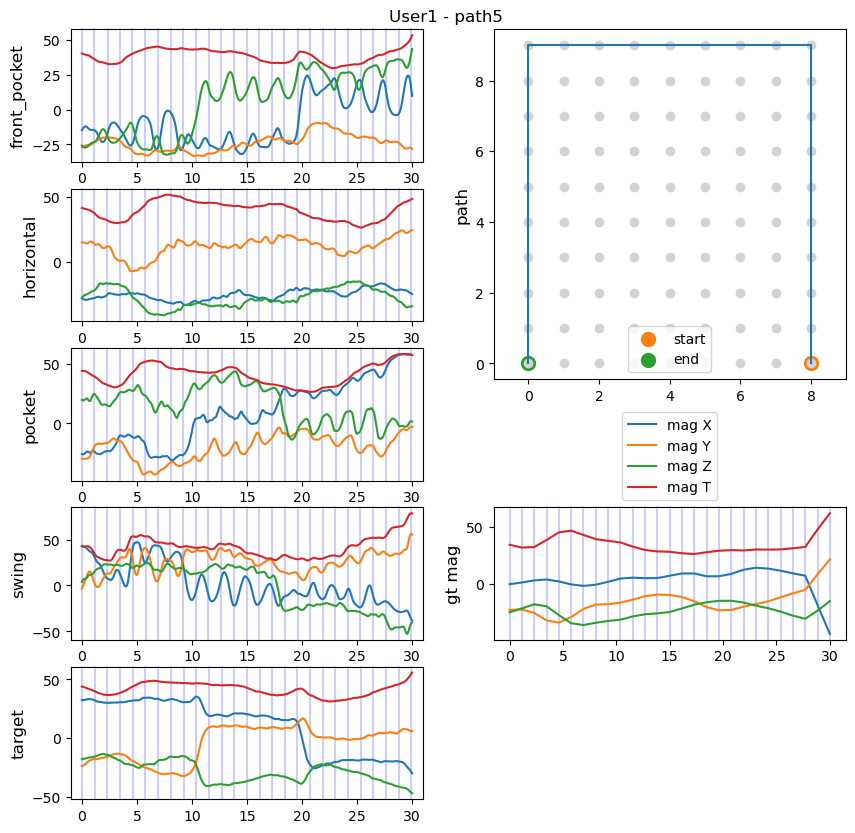

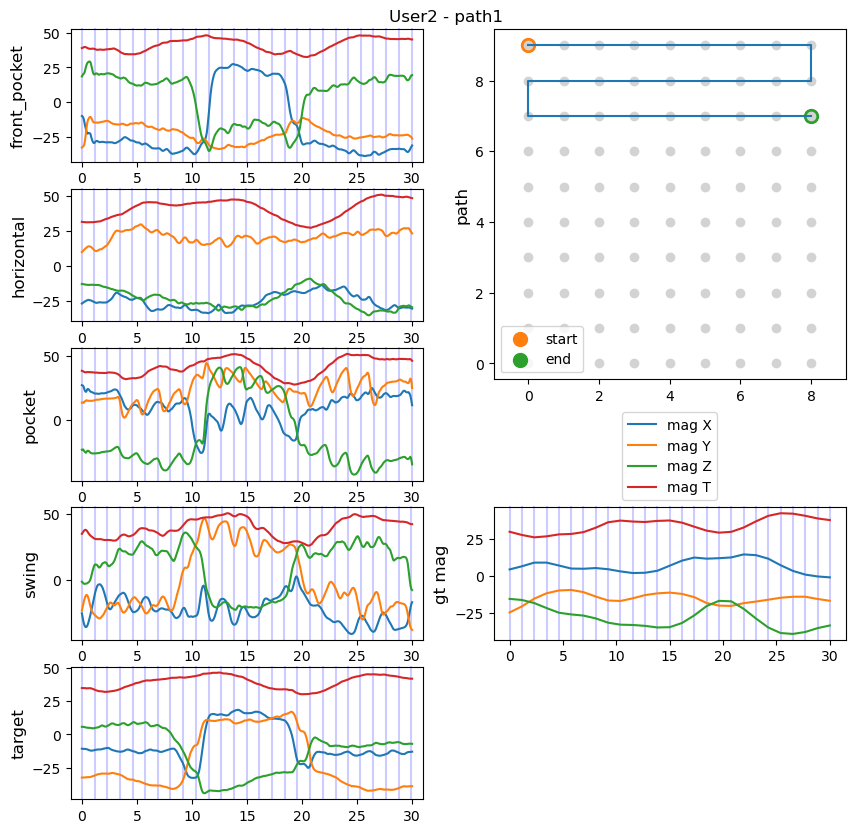

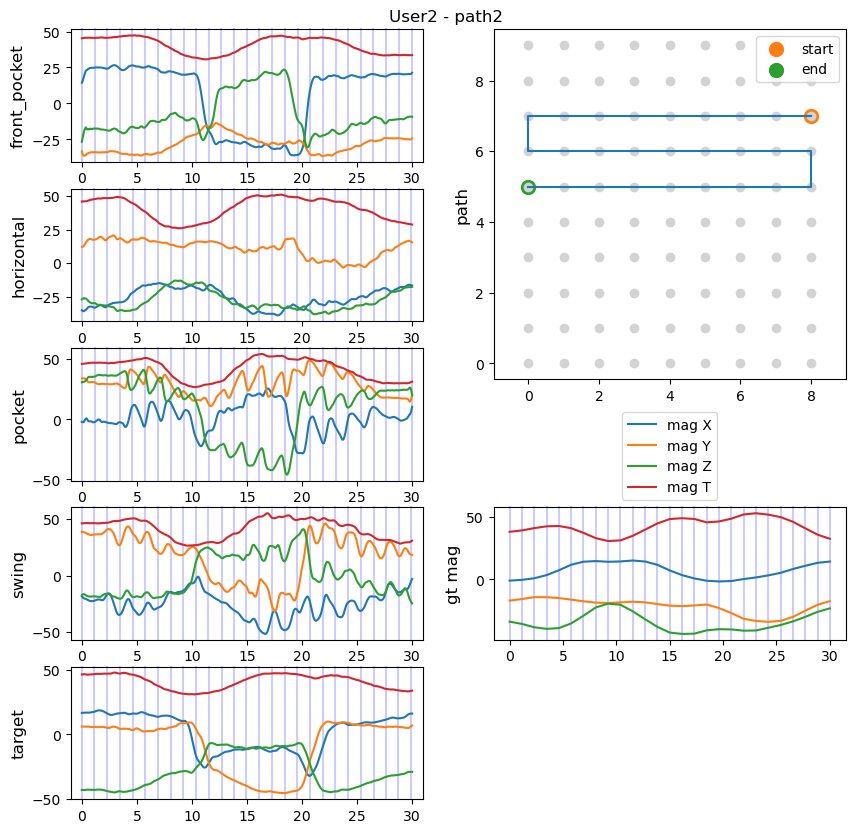

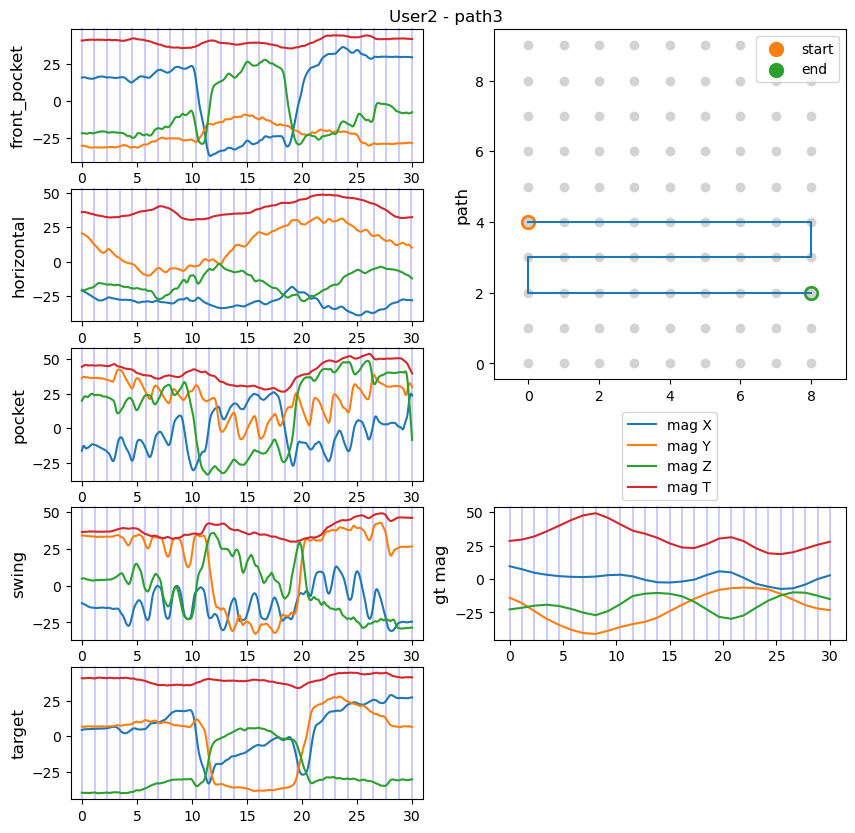

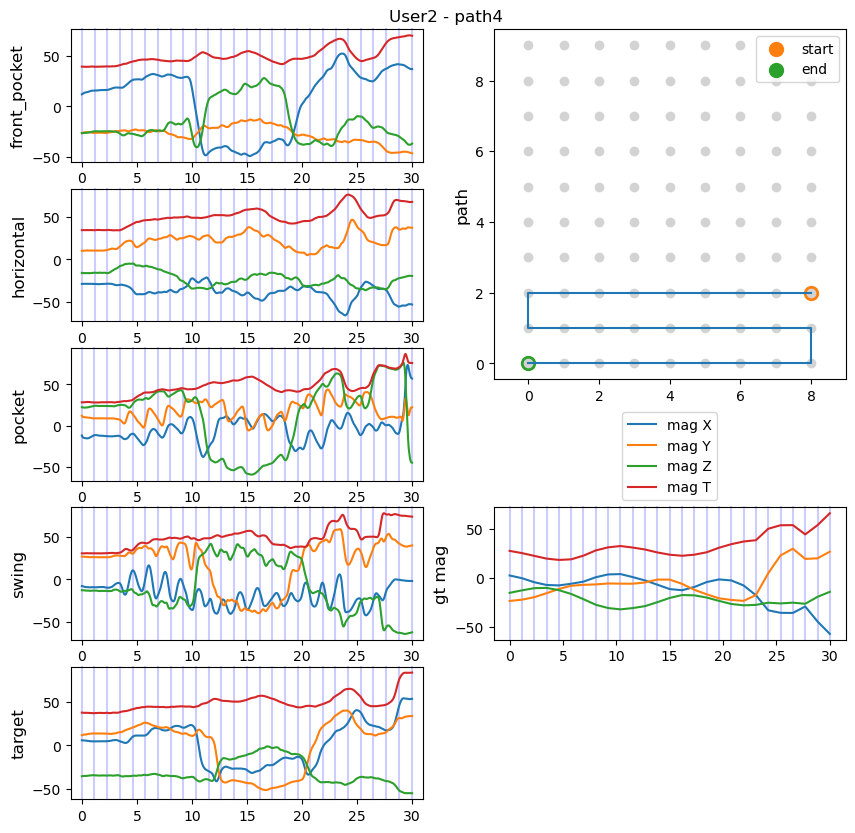

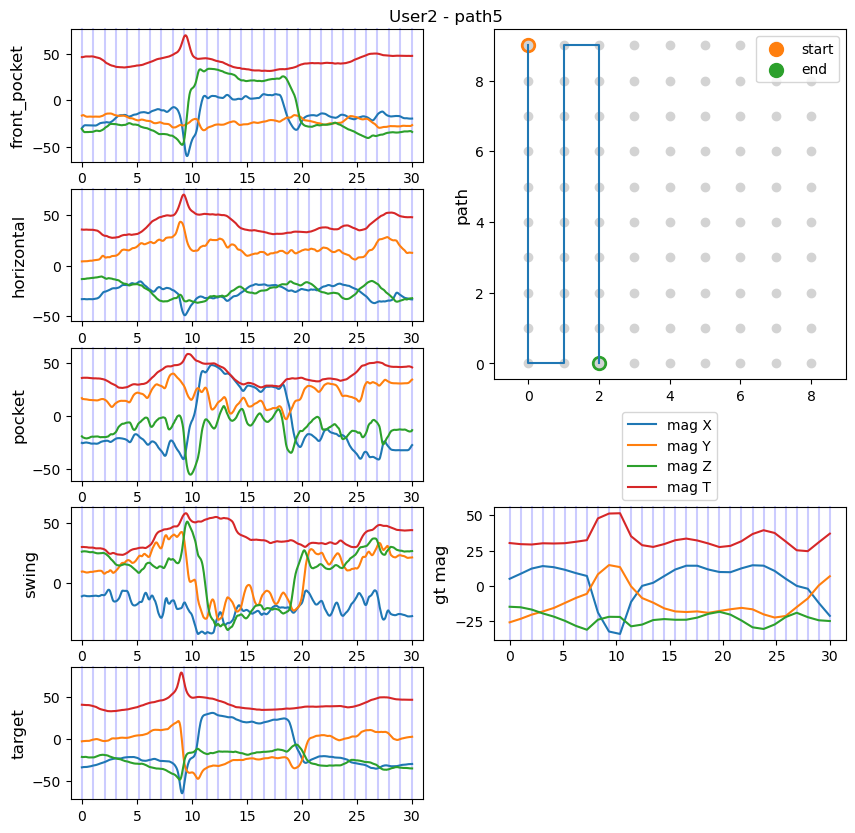

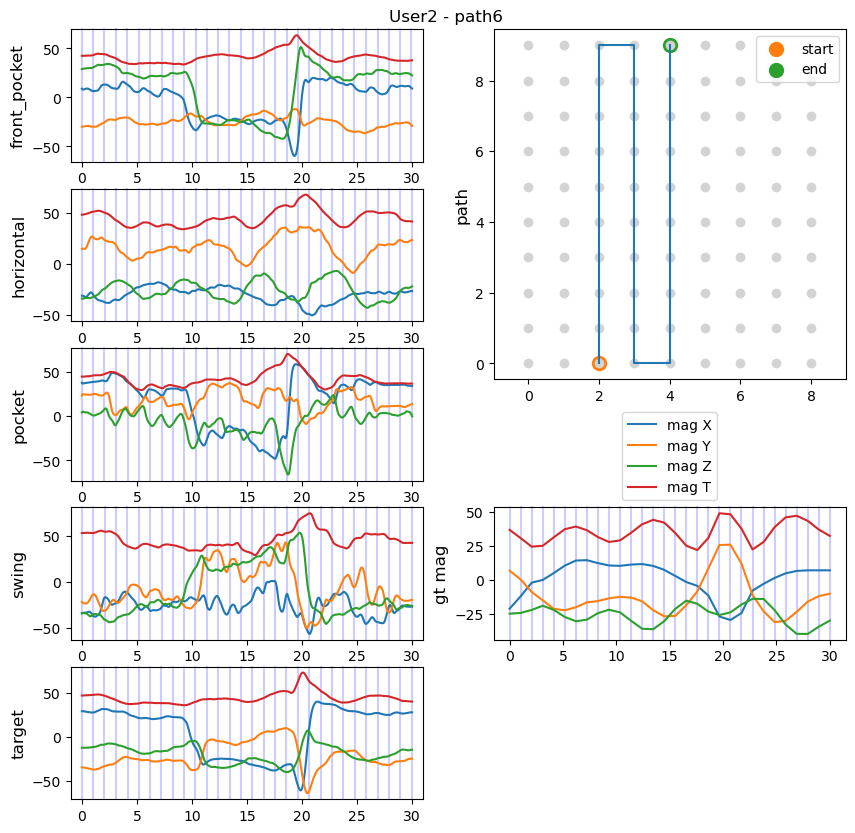

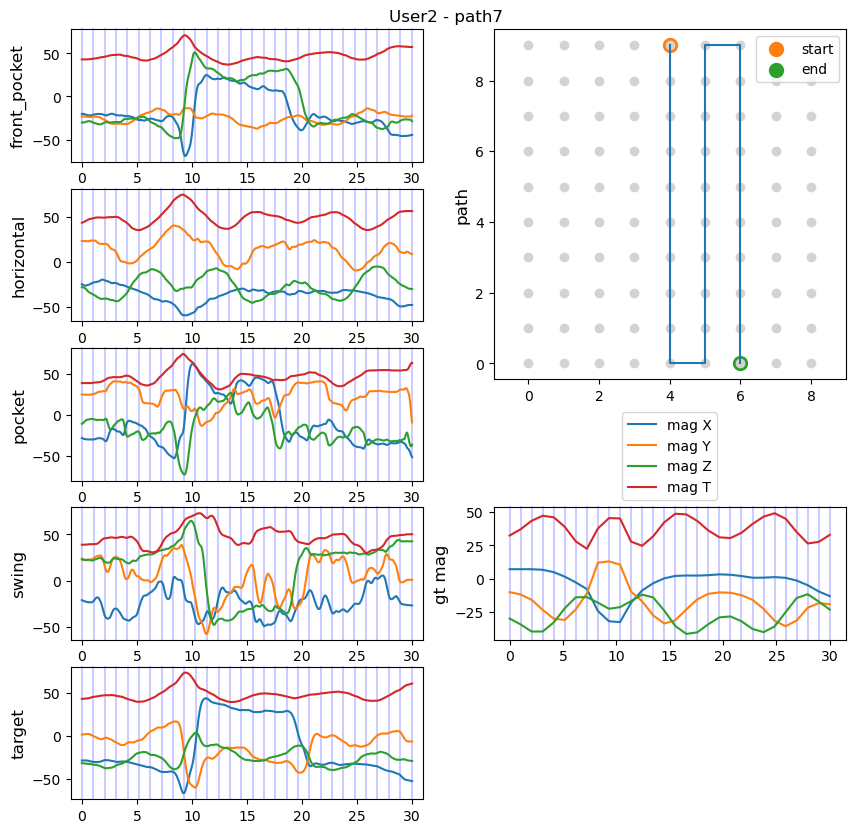

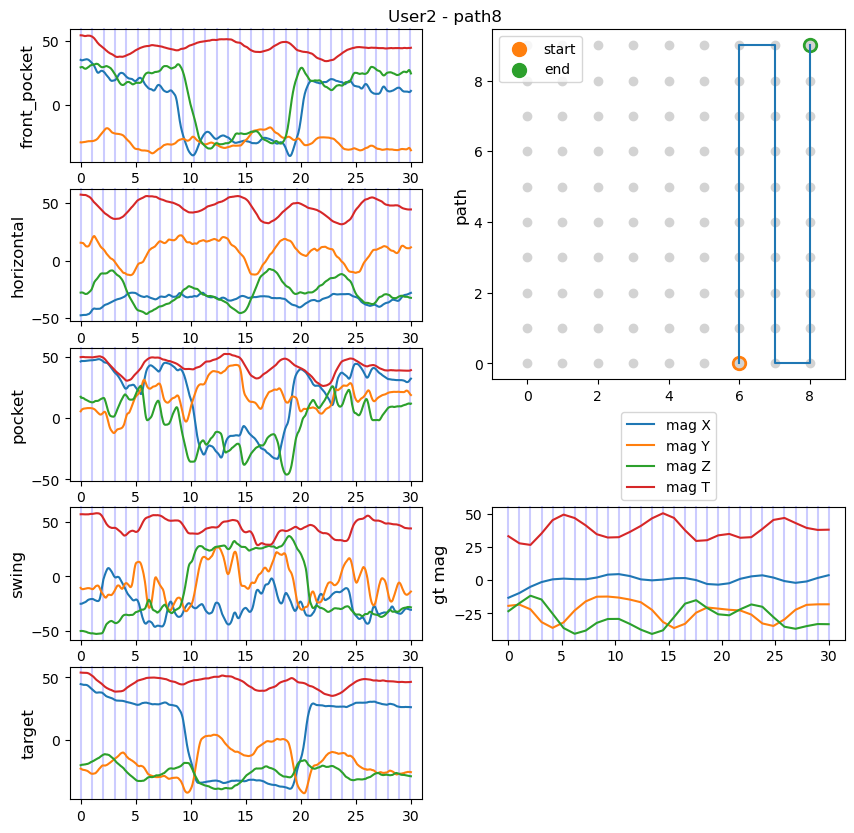

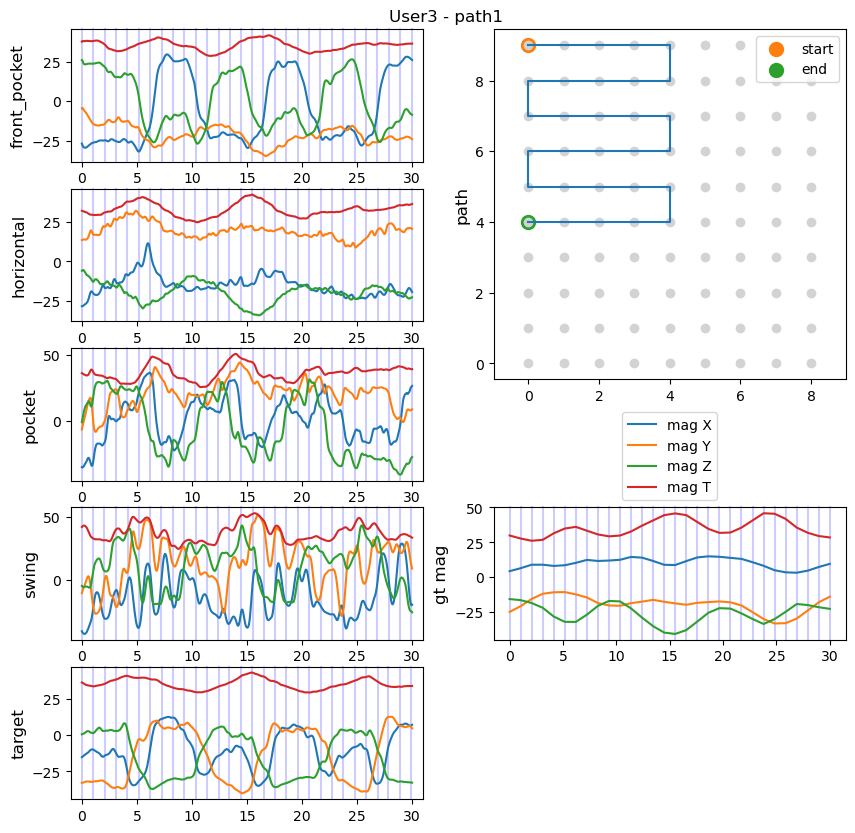

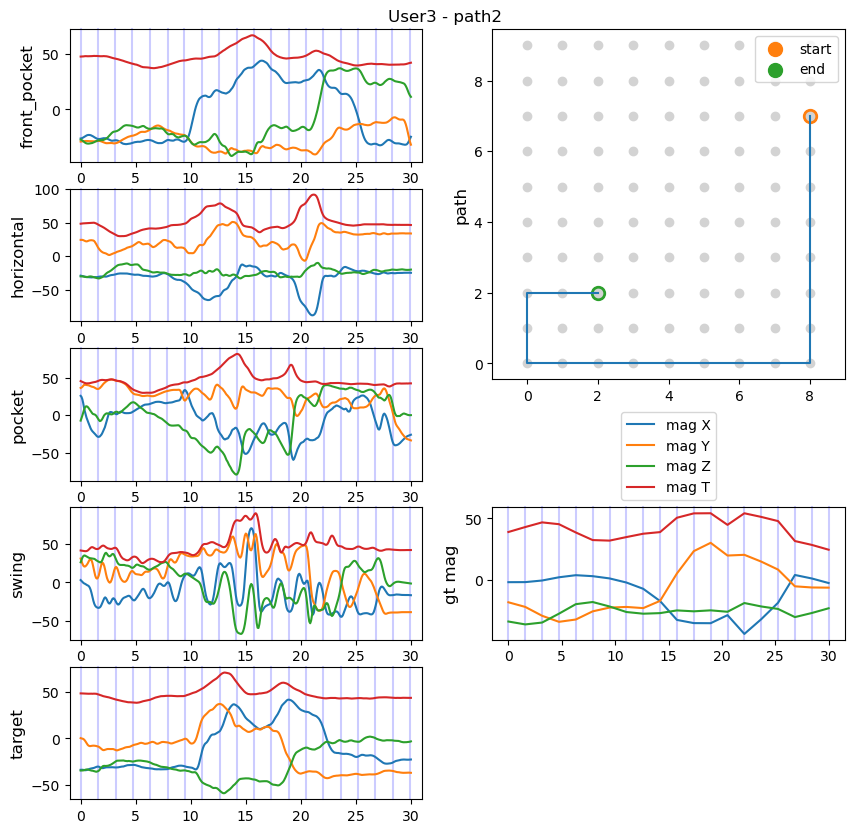

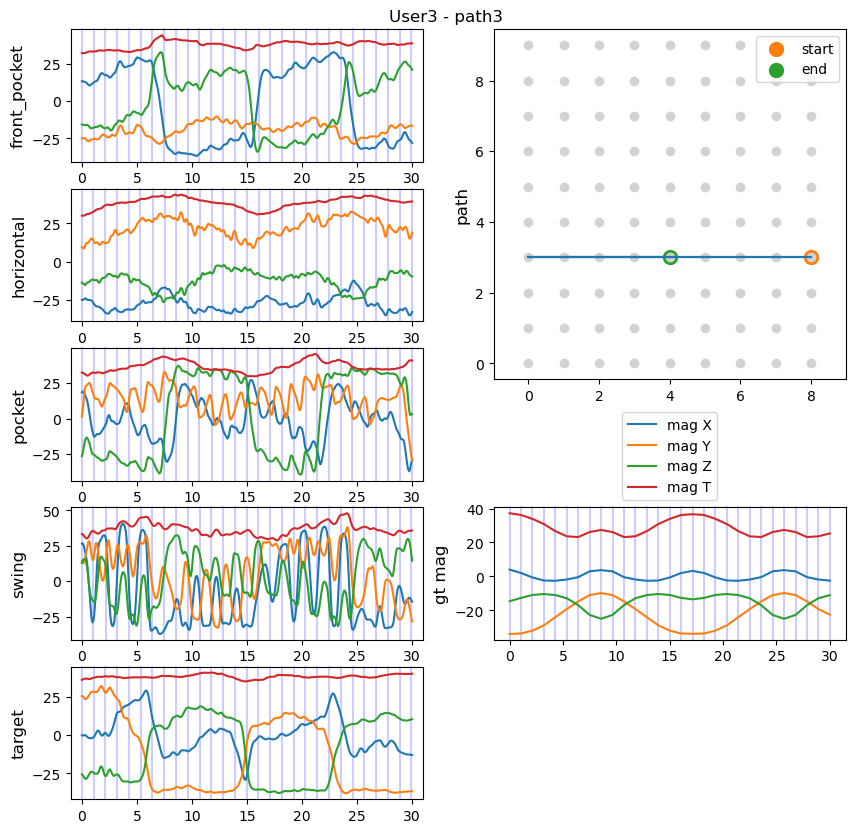

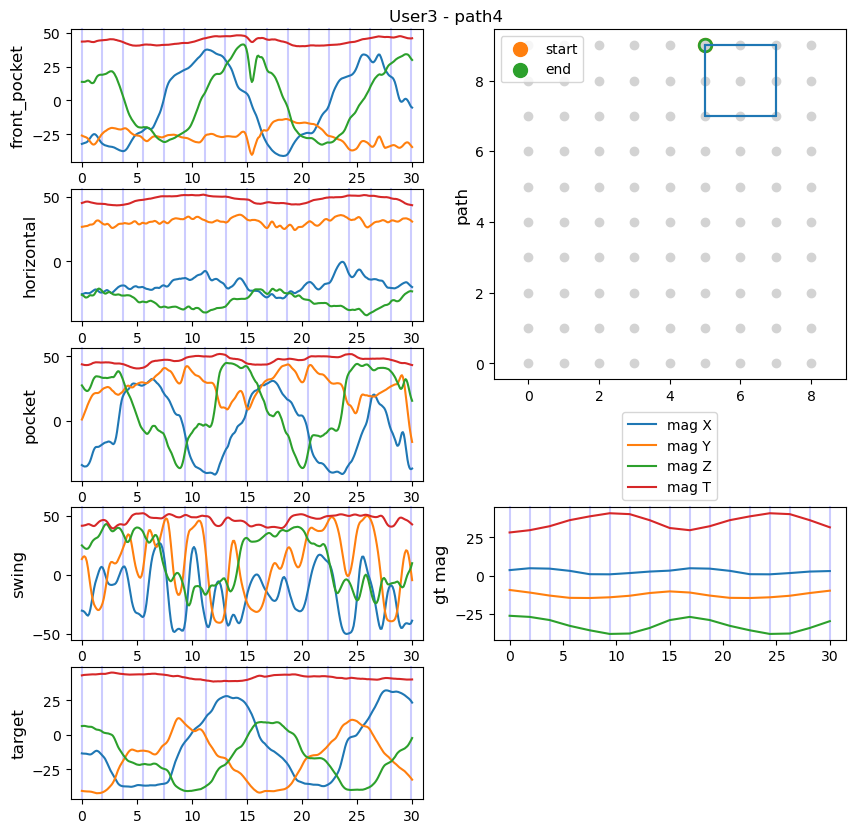

In [10]:
all_user_match_data = defaultdict(defaultdict)

for user_name in all_data.keys():
    for path_name in all_data[user_name].keys():
        plt.figure(figsize=(10, 10))
        all_user_match_data[user_name][path_name] = defaultdict()
        
        for i, posture_name in enumerate(all_data[user_name][path_name].keys()):
            data = all_data[user_name][path_name][posture_name]
            path_point = np.array(user_path[user_name][path_name])
            
            time = data[:, 0] - data[:, 0][0]
            time = time / np.max(time) * 30
            
            ### plot posture mag
            plt.subplot(5, 2, 2 * (i + 1) - 1)
            plt.plot(time, data[:, 10])
            plt.plot(time, data[:, 11])
            plt.plot(time, data[:, 12])
            plt.plot(time, data[:, 13])

            plt.xlim([-1, 31])
            plt.ylabel(posture_name.split('/')[-1], fontsize=12)

            split_index = [i / (len(path_point) - 1) * (len(data) - 1) for i in range((len(path_point)))]
            split_index = np.round(split_index).astype(int)
            
            all_user_match_data[user_name][path_name][posture_name] = np.concatenate((path_point, data[split_index]), axis=-1)
            
            for idx in split_index:
                x = idx / len(data) * 30
                plt.axvline(x=x, ymin=0, ymax=1, c='blue', zorder=0, clip_on=False, alpha=0.2)
        
        ### plot path
        plt.subplot(2, 2, 2)
        plt.plot(path_point[:, 1], path_point[:, 0])
        plt.scatter(path_point[0, 1], path_point[0, 0], s=100, c='tab:orange', label='start')
        plt.scatter(path_point[-1, 1], path_point[-1, 0], s=100, c='tab:green', label='end')
        plt.scatter(grid_data[:, 1], grid_data[:, 0], color='lightgray')
#         plt.gca().invert_yaxis()
        plt.legend()
        plt.ylabel(f'path', fontsize=12)
        plt.axis('equal')
        
        ### plot gt mag
        plt.subplot(5, 2, 8)
        idx = path_point[:, 1] + path_point[:, 0] * 9
        idx = idx.astype(int)
        mag = grid_data[idx]
        time = [i / (len(idx) - 1) * (30) for i in range((len(idx)))]
        
#         plt.plot(time, mag[:, 2], label='mag X')
#         plt.plot(time, mag[:, 3], label='mag Y')
#         plt.plot(time, mag[:, 4], label='mag Z')
#         plt.plot(time, np.sqrt(np.sum(np.power(mag[:, 2:5], 2), axis=-1)), label='mag T')

        plt.plot(time, moving_average(mag[:, 2], 3), label='mag X')
        plt.plot(time, moving_average(mag[:, 3], 3), label='mag Y')
        plt.plot(time, moving_average(mag[:, 4], 3), label='mag Z')
        plt.plot(time, moving_average(np.sqrt(np.sum(np.power(mag[:, 2:5], 2), axis=-1)), 3), label='mag T')

        plt.ylabel(f'gt mag', fontsize=12)
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1))
        
        for x in time:
            plt.axvline(x=x, ymin=0, ymax=1, c='blue', zorder=0, clip_on=False, alpha=0.2)
        
        # plt.axvline(x=0, ymin=-0.2, ymax=1, c='red', zorder=0, clip_on=False)
        plt.suptitle(f'{user_name} - {path_name}', x=0.5, y=0.9)
        plt.show()

In [11]:
np.save('window_5/all_user_match_data', all_user_match_data)